# Calc date Model exploration in PyTorch

## Import all required modules

In [1]:
import os
import shutil
import random
from ficc.utils.auxiliary_variables import PREDICTORS, IDENTIFIERS, CATEGORICAL_FEATURES, NON_CAT_FEATURES, BINARY
from ficc.data.process_data import process_data
from ficc.data.queries import *
from ficc.models import get_model_instance
import ficc.utils.attr as attr
from ficc.utils.eval import eval_model
import gcsfs

import pandas as pd
import numpy as np
from google.cloud import bigquery
from sklearn import preprocessing

import pickle

import torch
from torch.utils.data import TensorDataset, DataLoader, Subset
import torchvision.transforms as T
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.profiler import PyTorchProfiler
from torch.profiler import ProfilerActivity

import wandb

torch.multiprocessing.set_sharing_strategy('file_system')

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Seed the random-number generators

In [2]:
# Setting the random seed, for consistency
SEED = 10

pl.utilities.seed.seed_everything(SEED)

Global seed set to 10


10

## Set up the BigQuery client

In [3]:
# Setting up the credentials for GCP
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "eng-reactor-287421-112eb767e1b3.json"

# Initializing the big query client
bq_client = bigquery.Client()

## Set up hyper-parameters

In [4]:
# The batch size and learning rate have an impact on the smoothness of convergence of the model.\
# Larger the batch size the smoother the convergence. For a larger batch size we need a higher learning rate and vice-versa
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 10000
NUM_EPOCHS = 50

DROPOUT = 0.37909650481643176
SEQUENCE_LENGTH = 5
NUM_FEATURES = 5

## Data Preparation

In [5]:
with open('processed_data.pkl', 'rb') as f:
    df = pd.read_pickle(f)

In [6]:
df.purpose_class.fillna(1, inplace=True)

df = df[~df.purpose_sub_class.isin([6, 20, 21, 22, 44, 57, 90, 106])]
df = df[~df.called_redemption_type.isin([18, 19])]

# Add additional features
processed_data = df[IDENTIFIERS + PREDICTORS + ['trade_datetime']]

# A few features such as the initial issue amount cannot be filled with their logical counterparts as their values are not known and hence are dropped.
processed_data = processed_data.dropna()
unprocessed_data = processed_data.copy()

# Uniform normalization
normalizers = []
for num_col in NON_CAT_FEATURES + BINARY:
    normalizers.append(preprocessing.StandardScaler())
    processed_data[num_col] = normalizers[-1].fit_transform(processed_data[num_col].to_numpy().astype('float32').reshape(-1, 1))

# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(15, 10))
# ax.hist(processed_data.calc_day_cat)

## Prepare the datasets

In [7]:
# Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    encoders[f] = preprocessing.LabelEncoder().fit(
        processed_data[f].drop_duplicates())
    fmax[f] = np.max(encoders[f].transform(encoders[f].classes_))

# The create input function encodes the categorical features. It then combines the trade history, categorical, non-categorical, and binary features to return a NumPy array containing the data to be fed into the model.

def create_input(df):
    global encoders
    datalist = []
    datalist.append(torch.tensor(np.stack(df['trade_history'])).float())

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(
            df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(torch.tensor(np.concatenate(noncat_and_binary, axis=-1)))

    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(torch.tensor(encoded).long())
    return datalist

def create_ys_label(df):
    return torch.tensor(df.yield_spread.to_numpy()).float()

def create_cdc_label(df):
    return torch.tensor(df.calc_day_cat.to_numpy()).int()

def create_ys_cdc_label(df):
    return create_ys_label(df), create_cdc_label(df)

# Splitting the date into train and test set
test_dataframe = processed_data[processed_data.trade_datetime >= '2022-05-21']
train_dataframe = processed_data[processed_data.trade_datetime < '2022-05-21']
unprocessed_test_df = unprocessed_data[unprocessed_data.trade_datetime >= '2022-05-21']

# Split the training data in to train and validation set
val_dataframe = train_dataframe[train_dataframe.trade_datetime >= '2022-05-07']
train_dataframe = train_dataframe[train_dataframe.trade_datetime < '2022-05-07']

x_train = create_input(train_dataframe)
y_cd_train = create_cdc_label(train_dataframe)
train_dataset = TensorDataset(*x_train, y_cd_train)

x_val = create_input(val_dataframe)
y_cd_val = create_cdc_label(val_dataframe)
val_dataset = TensorDataset(*x_val, y_cd_val)

x_test = create_input(test_dataframe)
y_cd_test = create_cdc_label(test_dataframe)
test_dataset = TensorDataset(*x_test, y_cd_test)

## Get and train the model

In [8]:
# Initialize the wandb logger
wandb = WandbLogger(project="calc-date-exploration", entity="ficc-ai", name=f"Standalone calc-date model")

wandb: Currently logged in as: anis-ficc (ficc-ai). Use `wandb login --relogin` to force relogin


Instantiate the model below. Keeping this in a separate cell so I can selectively rerun only parts of the notebook and not force the model to re-train.

In [9]:
model_params = {
    'num_trade_history_features': NUM_FEATURES,
    'non_categorical_size': NON_CAT_FEATURES + BINARY,
    'category_sizes': fmax,
    'lstm_sizes': [50, 100],
    'embed_sizes': 15,
    'tabular_sizes': [400, 200, 100],
    'tabular_resblocks': 1,
    'final_sizes': [300, 100],
    'final_resblocks': 0,
    'dropout': 0.3758110031582248,
    'learning_schedule': 'constant', 
    'learning_rate': 0.002, 
    'weight_decay': 0.0004
}

model = get_model_instance(
    "lstm_calc_date_model_pytorch",
    **model_params)

Create the data-loaders and train the model

In [25]:

wandb.watch(model, log="all")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=16, shuffle=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=16, persistent_workers=True)

checkpoint = ModelCheckpoint(monitor="val_loss")
trainer = pl.Trainer(
    gpus=1 if torch.cuda.is_available() else 0,
    max_epochs=NUM_EPOCHS,
    callbacks=[
        checkpoint
    ],
    logger=wandb,
)

# Train the model
trainer.fit(model, train_loader, val_loader)

# Save a copy of the model somewhere convenient
shutil.copyfile(checkpoint.best_model_path, "best_cd_model.ckpt")

# Reload the checkpoint of the best model, to this point
print(f'Reloading best model {checkpoint.best_model_path}')
model = model.load_from_checkpoint(
    checkpoint_path=checkpoint.best_model_path,
    **model_params
)


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type       | Params
-------------------------------------------------------
0 | trade_history_lstm      | ModuleList | 72.2 K
1 | trade_history_dropout   | ModuleList | 0     
2 | trade_history_attention | ModuleList | 50.6 K
3 | trade_history_final     | Linear     | 10.1 K
4 | embed                   | ModuleList | 1.8 K 
5 | tabular_model           | Sequential | 218 K 
6 | final_stage             | Sequential | 91.2 K
7 | latent_reduction        | Linear     | 404   
8 | acc                     | Accuracy   | 0     
-------------------------------------------------------
444 K     Trainable params
0         Non-trainable params
444 K     Total params
1.778     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model /home/anis/ficc.ai/ficc/ml_models/sequence_predictors/calc-date-exploration/3vu4vl4p/checkpoints/epoch=27-step=7252.ckpt


Re-load the best model, to date.

In [10]:
# Reload the checkpoint of the best model, to this point
print(f'Reloading best model')
model = model.load_from_checkpoint(
    checkpoint_path='best_cd_model.ckpt',
    **model_params
)

Reloading best model


Evaluate the model, extract dataframes corresponding to when the model works, and when it doesn't. Store the soft-max logits for later analysis.

In [11]:
model.eval()

logits = torch.softmax(model.cuda()(*[x.cuda() for x in create_input(test_dataframe)]), dim=-1)
prediction = torch.argmax(logits, dim=1).squeeze().cpu().numpy()
logits = logits.detach().squeeze().cpu().numpy() # Convert to cpu now, so the above calc can occur on gpu
successes = prediction == y_cd_test.cpu().numpy()
success_dataframe = unprocessed_test_df[successes]
failures = prediction != y_cd_test.cpu().numpy()
failure_dataframe = unprocessed_test_df[failures]

print(f"Test accuracy is {np.count_nonzero(successes) / successes.shape[0]}")

Test accuracy is 0.9701842534856959


Generate the confusion matrix

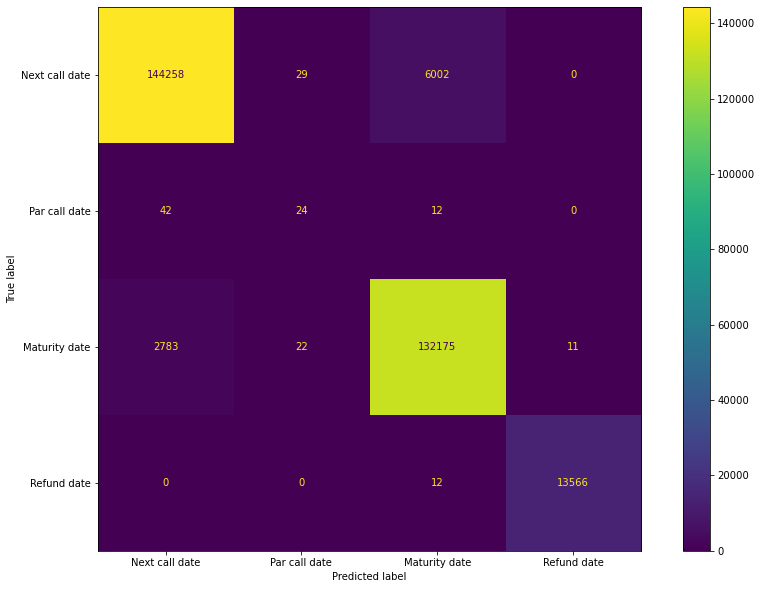

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(15, 10))
ConfusionMatrixDisplay.from_predictions(
    y_cd_test, 
    prediction, 
    display_labels=['Next call date', 'Par call date', 'Maturity date', 'Refund date'],
    ax=ax)
plt.show()

In [40]:
next_par_errors = ((prediction == 0) & (y_cd_test.cpu().numpy() == 1)) | ((prediction == 1) & (y_cd_test.cpu().numpy() == 0))
rtrs = test_dataframe[next_par_errors].rtrs_control_number
next_par_df = df.loc[df['rtrs_control_number'].isin(rtrs)]
print(f'{np.count_nonzero(next_par_df.next_call_date == next_par_df.par_call_date)} out of {len(next_par_df)} next/par-call date mismatches were for the same date')

mat_par_errors = ((prediction == 2) & (y_cd_test.cpu().numpy() == 1)) | ((prediction == 1) & (y_cd_test.cpu().numpy() == 2))
rtrs = test_dataframe[mat_par_errors].rtrs_control_number
mat_par_df = df.loc[df['rtrs_control_number'].isin(rtrs)]
print(f'{np.count_nonzero(mat_par_df.maturity_date == mat_par_df.par_call_date)} out of {len(mat_par_df)} maturity/par-call date mismatches were for the same date')

mat_refund_errors = ((prediction == 2) & (y_cd_test.cpu().numpy() == 3)) | ((prediction == 3) & (y_cd_test.cpu().numpy() == 2))
rtrs = test_dataframe[mat_refund_errors].rtrs_control_number
mat_refund_df = df.loc[df['rtrs_control_number'].isin(rtrs)]
print(f'{np.count_nonzero(mat_refund_df.maturity_date == mat_refund_df.refund_date)} out of {len(mat_refund_df)} maturity/refund date mismatches were for the same date')

mat_next_errors = ((prediction == 2) & (y_cd_test.cpu().numpy() == 0)) | ((prediction == 0) & (y_cd_test.cpu().numpy() == 2))
rtrs = test_dataframe[mat_next_errors].rtrs_control_number
mat_next_df = df.loc[df['rtrs_control_number'].isin(rtrs)]
print(f'{np.count_nonzero(mat_next_df.maturity_date == mat_next_df.next_call_date)} out of {len(mat_next_df)} maturity/next-call date mismatches were for the same date')

29 out of 71 next/par-call date mismatches were for the same date
0 out of 34 maturity/par-call date mismatches were for the same date
0 out of 23 maturity/refund date mismatches were for the same date
0 out of 8785 maturity/next-call date mismatches were for the same date


Plot out a few key input features, as well as violin-plots of the logits' confidence levels.

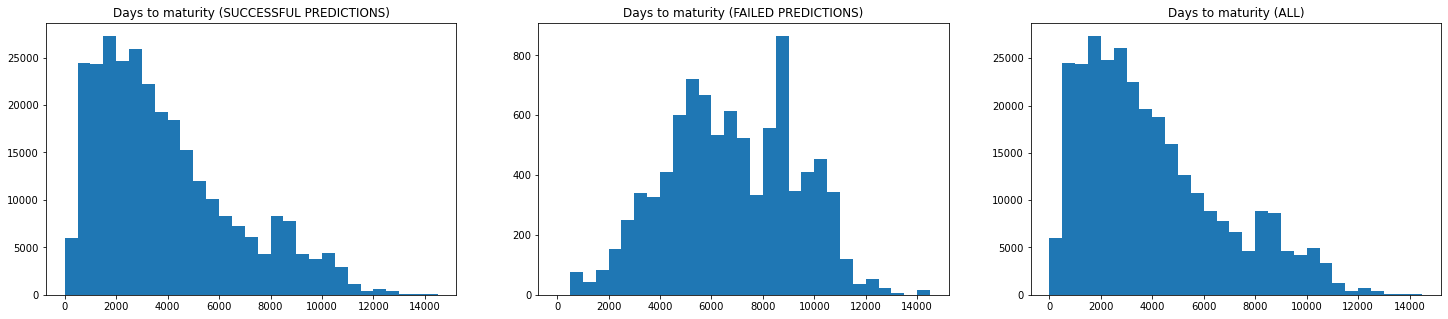

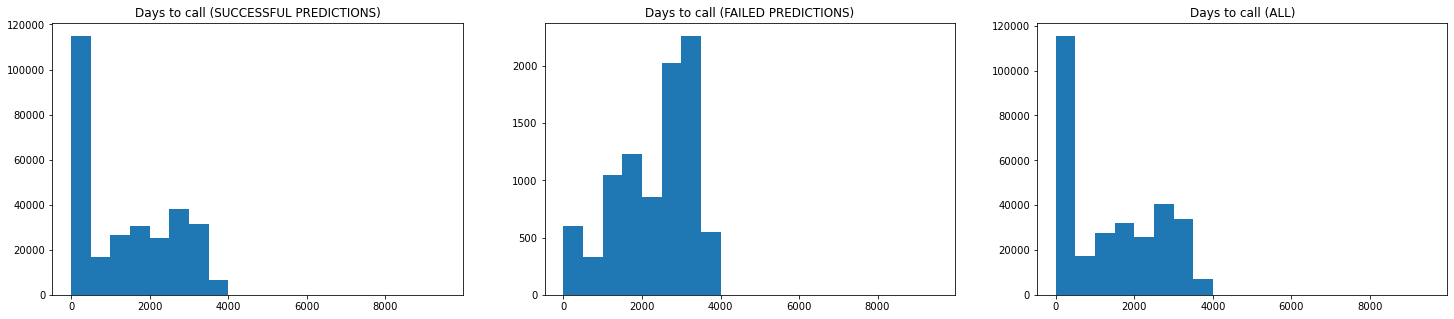

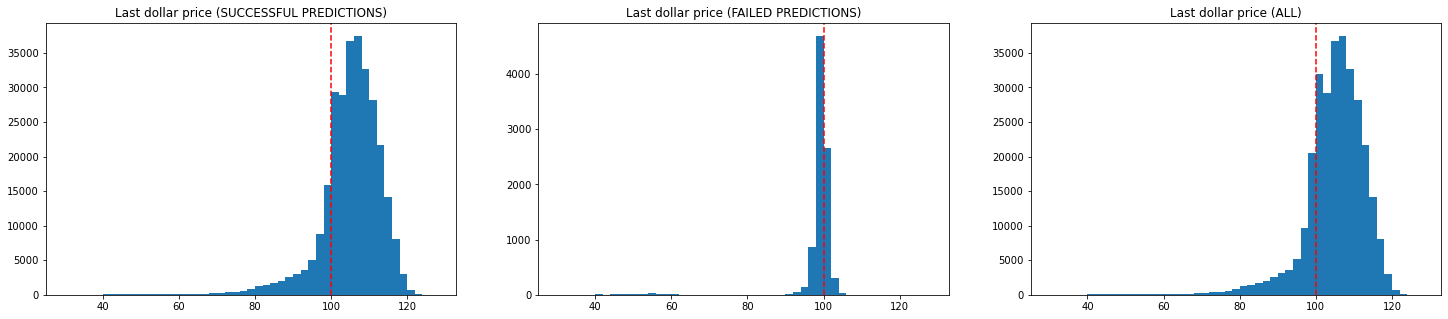

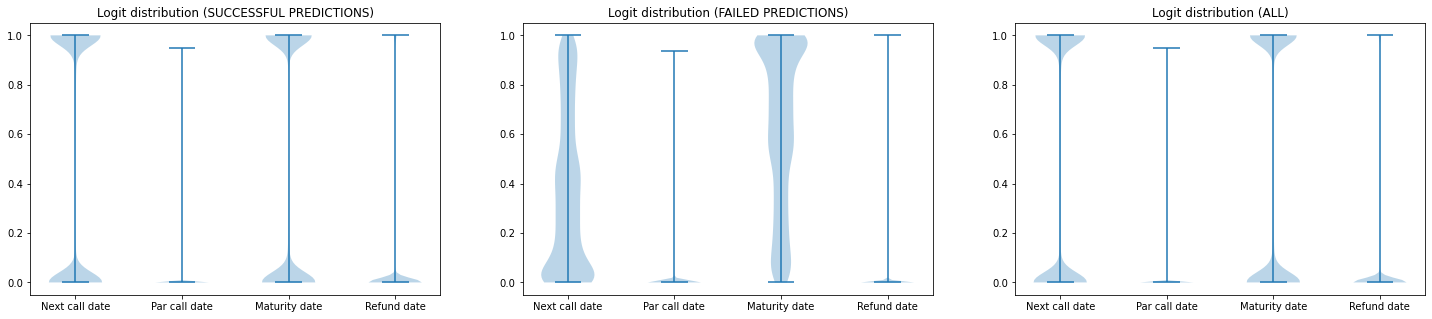

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(10.0 ** success_dataframe.days_to_maturity, bins=range(0, 15000, 500))
ax[0].set_title('Days to maturity (SUCCESSFUL PREDICTIONS)')
ax[1].hist(10.0 ** failure_dataframe.days_to_maturity, bins=range(0, 15000, 500))
ax[1].set_title('Days to maturity (FAILED PREDICTIONS)')
ax[2].hist(10.0 ** unprocessed_test_df.days_to_maturity, bins=range(0, 15000, 500))
ax[2].set_title('Days to maturity (ALL)')
plt.show()
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(10.0 ** success_dataframe.days_to_call, bins=range(0, 10000, 500))
ax[0].set_title('Days to call (SUCCESSFUL PREDICTIONS)')
ax[1].hist(10.0 ** failure_dataframe.days_to_call, bins=range(0, 10000, 500))
ax[1].set_title('Days to call (FAILED PREDICTIONS)')
ax[2].hist(10.0 ** unprocessed_test_df.days_to_call, bins=range(0, 10000, 500))
ax[2].set_title('Days to call (ALL)')
plt.show()
# Days to Settle/Refund didn't show differences, so they were removed
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(success_dataframe.last_dollar_price, bins=range(30, 130, 2))
ax[0].set_title('Last dollar price (SUCCESSFUL PREDICTIONS)')
ax[0].axvline(100.0, color='r', linestyle='--')
ax[1].hist(failure_dataframe.last_dollar_price, bins=range(30, 130, 2))
ax[1].set_title('Last dollar price (FAILED PREDICTIONS)')
ax[1].axvline(100.0, color='r', linestyle='--')
ax[2].hist(unprocessed_test_df.last_dollar_price, bins=range(30, 130, 2))
ax[2].set_title('Last dollar price (ALL)')
ax[2].axvline(100.0, color='r', linestyle='--')
plt.show()
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].violinplot(dataset=logits[successes],positions=range(4))
ax[0].set_title('Logit distribution (SUCCESSFUL PREDICTIONS)')
ax[0].set_xticks(range(4))
ax[0].set_xticklabels(['Next call date', 'Par call date', 'Maturity date', 'Refund date'])
ax[1].violinplot(dataset=logits[failures],positions=range(4))
ax[1].set_title('Logit distribution (FAILED PREDICTIONS)')
ax[1].set_xticks(range(4))
ax[1].set_xticklabels(['Next call date', 'Par call date', 'Maturity date', 'Refund date'])
ax[2].violinplot(dataset=logits,positions=range(4))
ax[2].set_title('Logit distribution (ALL)')
ax[2].set_xticks(range(4))
ax[2].set_xticklabels(['Next call date', 'Par call date', 'Maturity date', 'Refund date'])
plt.show()


In [ ]:
x_test = create_input(test_dataframe)
y_test = create_cdc_label(test_dataframe)
test_loader = DataLoader(TensorDataset(*x_test, y_test), batch_size=BATCH_SIZE, num_workers=os.cpu_count())
results = trainer.test(model, test_loader, verbose=False)
wandb.experiment.log({"Full Test Accuracy": results[0]['test_accuracy']})

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/home/anis/anaconda3/envs/ficc/lib/python3.9/site-packages/captum/attr/_core/layer/layer_integrated_gradients.py:102: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  warnings.warn(
/home/anis/anaconda3/envs/ficc/lib/python3.9/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 1000 equal to the number of examples.
  warnings.warn(
/home/anis/anaconda3/envs/ficc/lib/python3.9/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 936 equal to the number of examples.
  warnings.warn(


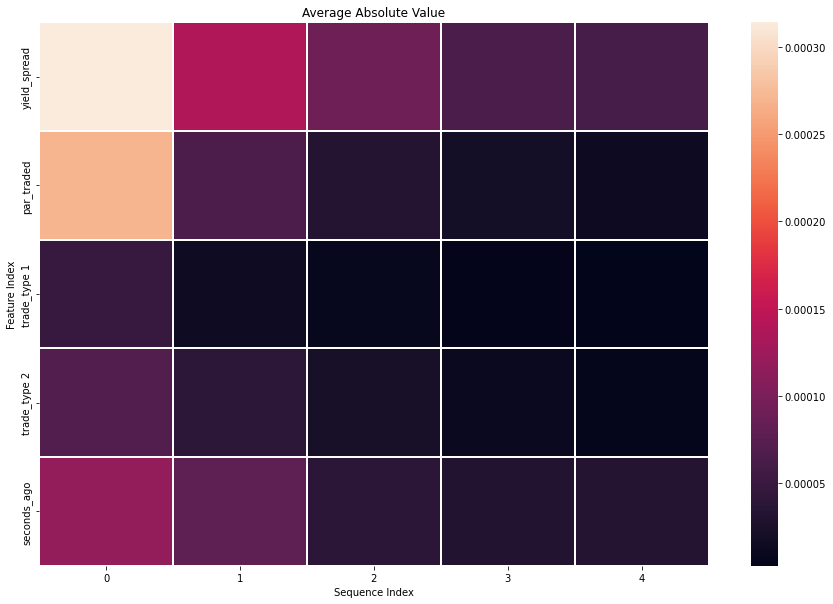

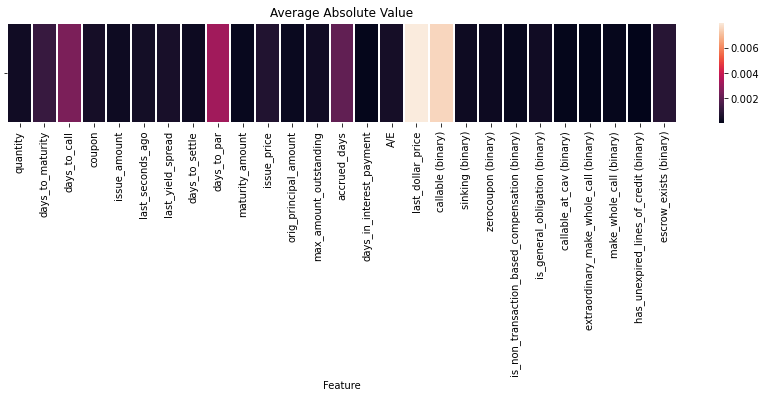

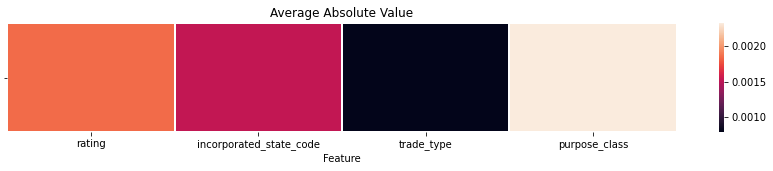

In [ ]:
model.train()
attributes = attr.compute_integrated_gradient_calc_date_error_attributions(model, x_test, y_cd_test)
attr.visualize_trade_history_attribution(attributes[0].abs().mean(dim=0), subtitle="Average Absolute Value", wandb=wandb.experiment)
attr.visualize_trade_numerical_and_binary_attribution(attributes[1].abs().mean(dim=0), NON_CAT_FEATURES, BINARY, subtitle="Average Absolute Value", wandb=wandb.experiment)
attr.visualize_categorical_attribution(torch.cat([a.unsqueeze(1) for a in attributes[2:]], dim=-1).mean(dim=0), CATEGORICAL_FEATURES, subtitle="Average Absolute Value", wandb=wandb.experiment)

In [ ]:
wandb.experiment.finish()

Full Test Accuracy,█▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,█▁
test_loss,▁█
train_accuracy,▁▂▅▆▅▆▆▆▇▇▇▆▇▆▇▆▇▆▇▆▆▇▇▆▆▇█▇▇█▇█▇█▆▇▇▆▆▇
train_loss,█▆▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▃▂▂▂▂▁▁▂▂▁▂▁▂▁▂▂▂▂▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_accuracy,▂▁▄▆▆▂▂▇▄▅▇▇▇██▇█▆▇█▆▇██▇█▇▅▇▄▆█▆█▇▅██▇█
val_loss,▇█▆▃▃▇▅▂▄▄▂▁▂▁▁▂▁▃▂▁▂▃▁▂▂▂▂▅▂▅▃▂▃▂▃▃▂▃▃▂
Full Test Accuracy,0.9472
epoch,50
